In [1]:
%pylab inline
from neuron import h, gui
from scipy.signal import *
import pandas
#%pylab tk
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [26]:
# Ih activation curve from BO 2001
v = linspace(-150.,0.,301)

F = 96485.
R = 8.314
T = 22.
T_z = 273.
C_t = (0.003*F)/(R*(T_z+T))
Q_t = 4.5**((T-33.)/10.)
h_inf = lambda v: 1/(1+e**((v+66.)/7.))
tau_h = lambda v,C_t: (e**(0.6*(v+84.)*C_t))/(Q_t*0.0029*(1+e**((v+84.)*C_t)))

# Ih from RM03c
r_inf= lambda v: 1/(1+e**((v+76.)/7.))

0.152608664843 0.429053403117


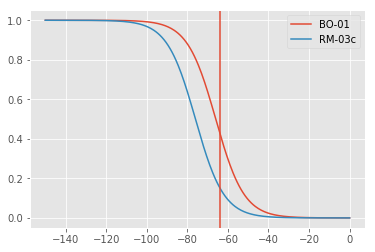

In [27]:
plot(v,h_inf(v), label='BO-01')
plot(v,r_inf(v), label='RM-03c')
axvline(-64)

legend()

print r_inf(-64), h_inf(-64)

In [29]:
h_inf(-60)

0.2979366301210704

In [2]:
#CVODE не работает с оригинальными файлами из (Rothman and Manis 2003)
h.cvode_active(0)

0.0

## Используем модель Rothman and Manis 2003

In [3]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [4]:
total_capacitance = 12 # pF

soma_area = total_capacitance * 1e-6 / 1 # pF -> uF, 1 uF/cm^2
soma_diam = 1e4*sqrt(soma_area/pi) # cm->um

print 'Soma area: %.2e cm^2, diameter: %2.2f um'%(soma_area,soma_diam)

Soma area: 1.20e-05 cm^2, diameter: 19.54 um


In [5]:
currents = ['klt', 'kht', 'na', 'ka', 'ih', 'hcno', 'leak']

In [6]:
def ns_to_mhocm2(x):
    "Convert from nanosiemens to siemens/cm^2"
    return 1e-9*x/soma_area

In [7]:
ptypeII = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 200),
          ('gabar', 0),  ('ghbar', 20), ('ghcno', 0), ('glk', 2), ]}

ptypeIIo = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 600),
          ('gabar', 0),  ('ghbar', 0), ('ghcno', 40), ('glk', 2), ]}

ptypeIc = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar', 1000), ('gkhtbar', 150), ('gkltbar', 0),
          ('gabar', 0), ('ghbar', 0.5), ('ghcno', 0), ('glk', 2)]}

ptypeIt = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar', 1000), ('gkhtbar', 80), ('gkltbar', 0),
          ('gabar', 65), ('ghbar', 0.5), ('ghcno', 0), ('glk', 2)]}

ptypeIc['Vm0'] = -63.9
ptypeIt['Vm0'] = -64.2
ptypeII['Vm0'] = -63.6 # mV
ptypeIIo['Vm0'] = -66.67 

ptypeIc['Rin'] = 473
ptypeIt['Rin'] = 453
ptypeII['Rin'] = 71    # MOhm
ptypeIIo['Rin'] = 6.7 
# in S/cm^2

In [8]:
bushy = h.Section(name='bushy') 
octopus = h.Section(name='octopus')
stellatec = h.Section(name='stellatec')
stellatet = h.Section(name='stellatet')

neurons = [(bushy, ptypeII), (octopus, ptypeIIo), (stellatec, ptypeIc), (stellatet, ptypeIt)]

In [9]:
def init_neurons():
    h.celsius = 22 # Normal temperature is 38 °C # See the difference after cel=37 in current kinetics (below)
                    # ~ No difference in resting energy consumption
    for npx in neurons:
        n,p = npx
        n.nseg = 1
        n.diam = soma_diam
        n.L = soma_diam
        n.Ra = 150
        n.cm = 1
    
        for cur in currents:
            n.insert(cur)
    
        # add and init 'pseudo-mechanism' 
        # to calculate energy rate in *each segment*
        n.insert('mujpow')
        if (n.name() == octopus):
            h.setpointer(n(0.5)._ref_i_hcno, 'i_ih', n(0.5).mujpow)
            h.setpointer(n(0.5)._ref_thegna_hcno, 'gh', n(0.5).mujpow)
        else:
            h.setpointer(n(0.5)._ref_i_ih, 'i_ih', n(0.5).mujpow)
            h.setpointer(n(0.5)._ref_gh_ih, 'gh', n(0.5).mujpow)       
            
        n.ek = -70
        n.ena = 50
        n.gnabar_na = p['gnabar']
        n.gkhtbar_kht = p['gkhtbar']
        n.gkltbar_klt = p['gkltbar']
        n.gkabar_ka = p['gabar']
        n.ghbar_ih = p['ghbar']
        n.gbar_hcno = p['ghcno']
        n.g_leak = p['glk']

        
init_neurons()

In [10]:
v_vecb = h.Vector()             # Membrane potential vector
v_veco = h.Vector()
v_vecsc = h.Vector()
v_vecst = h.Vector()
t_vec = h.Vector()             # Time stamp vector

v_vecb.record(bushy(0.5)._ref_v)
v_veco.record(octopus(0.5)._ref_v)
v_vecsc.record(stellatec(0.5)._ref_v)
v_vecst.record(stellatet(0.5)._ref_v)

t_vec.record(h._ref_t)


1.0

In [11]:
h.v_init = ptypeII['Vm0']

h.tstop = 2000

h.run()

(-1, 20)

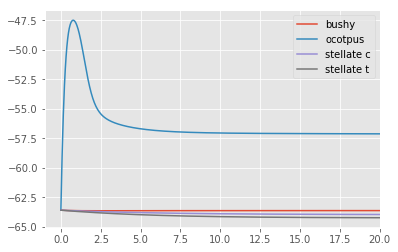

In [14]:
# celsius = 22
plot(t_vec, v_vecb, label='bushy')
plot(t_vec,v_veco, label='ocotpus')
plot(t_vec, v_vecsc, label='stellate c')
plot(t_vec, v_vecst, label='stellate t')
legend ()
#ylim(-70,-50)
xlim(-1,20)

In [16]:
def split_ih(seg, eh=-43):
    "splits ih to Na and K components (crude)"
    v = seg.v
    if seg.gbar_hcno != 0.0:
        gh = seg.thegna_hcno
    if seg.ghbar_ih != 0.0:
        gh = seg.ih.gh
    gr = float((seg.ena-eh))/(eh-seg.ek)
    denom = (v*(gr+1) - gr*seg.ek - seg.ena)
    if (abs(v-eh) < 1):
        gnah = gh/(gr + 1)
    else: 
        if seg.gbar_hcno != 0.0:
            gnah = seg.i_hcno/denom
        if seg.ghbar_ih != 0.0:
            gnah = seg.i_ih/denom
    inah = gnah*(v-seg.ena)
    ikh = gr*gnah*(v-seg.ek)
    return inah, ikh

def check_splitting(v, gratio=5, eh=-43, ek=-70, ena =50):
    ih = ptypeII['ghbar']*(v-eh)
    gr = float((ena-eh))/(eh-ek)
    print gr
    denom = gr*(v-ek) + (v-ena)
    gnah = ih/denom
    inah = gnah*(v-ena)
    ikh = gr*gnah*(v-ek)
    return  inah, ikh, denom

def split_mixed(v, gm, erev,ek=-70,ena=50):
    gratio = float((ena-erev))/(erev-ek)
    denom = (v*(gratio+1) - gratio*ek - ena)
    if (abs(v-erev) < 1):
        gnah = gm/(gratio + 1)
    else: 
        gnah = gm*(v-erev)/denom
    inah = gnah*(v-ena)
    ikh = gratio*gnah*(v-ek)
    return inah, ikh

3.44444444444


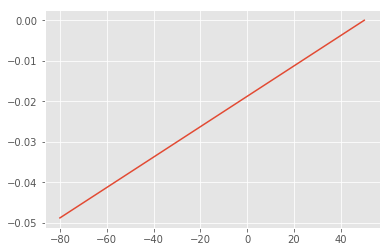

In [24]:
vtest = linspace(-80, 50, 1000)

gratio = 5
ek = -70
ena = 50

plot(vtest, check_splitting(vtest, eh=-43)[0])
#plot(vtest, check_splitting(vtest, eh=-43)[1])
#k = argmin( abs(check_splitting(vtest, eh=-43)))
#vtest[k]

In [18]:
def get_Rin(sec):
    seg = sec(0.5)
    gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
    gkr = seg.ik/(seg.v-seg.ek)
    ghr = seg.i_ih/(seg.v- -43)
    glkr = seg.leak.i/(seg.v -seg.erev_leak)
    Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
    return 1e-6/Ginx 

for n in neurons:
    print '{} Rin: {} | {} MOhm'.format(n[0].name(), get_Rin(n[0]), n[1]['Rin'])

bushy Rin: 71.0284615727 | 71 MOhm
octopus Rin: 18.0806915965 | 6.7 MOhm
stellatec Rin: 473.112176395 | 473 MOhm
stellatet Rin: 452.143818316 | 453 MOhm


In [21]:
def SetSyn(cell, Ens=dict(), Syn=dict(), Con=dict()):
    nn = cell.name()
    Ens[nn] = h.NetStim()
    Syn[nn] = h.ExpSyn(cell(.5))
    Syn[nn].tau = 0.4 #RM03
    Con[nn] = h.NetCon(Ens[nn], Syn[nn], 0,0,2e-3)
    return Ens, Syn, Con

def SetSynParams(cell,Ens,n,interval,noise,weight=None, Con=None):
    nn = cell.name()
    Ens[nn].number = n
    Ens[nn].interval = interval
    Ens[nn].noise = noise
    if weight != None:
        Con[nn].weight[0] = weight
        
def SetRec(cell):
    t_, v_ = h.Vector(),h.Vector()
    
    t_.record(h._ref_t)
    v_.record(cell(.5)._ref_v)
    return t_,v_

In [22]:
# Use single Synapses with Gbars from table 1 (RM03c) at 22 degC 

gsyns = {'octopus':8.6e-3, 'bushy':8.6e-3, 'stellatet':2.2e-3, 'stellatec':2.0e-3} # uS

In [40]:
### Instruments for energy calculation in NEURON models  ###

avogadro = 6.022*1e23 # molecules/mol
F_ATP = 50 # kJ/mol

def find_nearest(array, value):
    idx = np.abs(array - value).argmin()
    return idx

# --- MIXED CURRENT SPLITTER ---
def split_mixed(v, g_mixed, erev_mixed, ek,ena):
    g_r = float((ena-erev_mixed))/float(erev_mixed-ek)
    
    denom = (v*(g_r+1) - g_r*ek - ena) # mV
    
    if (abs(v-erev_mixed) < 1): # Escape from 0/0 uncertainty in proximity to erev_mixed (Taylor series of the *)
        gnam = g_mixed/(g_r + 1)
    else: 
        gnam = g_mixed*(v-erev_mixed)/denom # 
    
    inam = gnam*(v-ena)
    ikm = g_r*gnam*(v-ek)
    return inam, ikm

# --- CONVERTERS ---
def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Converts pmol ATP/s to energy usage in Joule/s"
    return F_ATP * nATP * 1e3

def J2atp(nJ):
    "Converts Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3

# --- INSTANT ENERGY CALC ---
def ratp_atwell(V, Rin, ek=-70, ena=55):
    """ Returns resting ATP consumption rate in pmol ATP/s.
        Uses Attwell & Laughlin (2001 JCBFM) formula."""
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (ena-V)*(V-ek)/(F*Rin*(V + 2*ena - 3*ek))
    return out*1e3 # nmol -> pmol

def mouj_Erate2(seg, currents_of_interest = None, g_mixed = None, erev_mixed = None, mode=None):
    """
    Returns: Instant 'Electrical' energy in pJ/s. Splits mixed currents, taking
    gbars and erevs from 'g_mixed' and 'erev_mixed' if they are given (array-like).
        mode = None       => Total Energy is returned;
        mode = 'Detailed' => Total E + Specific E for 'currents_of_interest'.
        Currents_of_interest should be of the form: 
        
                    [["hoc mechanism SUFFIX.Variable","corresponding E_rev"],
                     [...,...],]
                    
        -- ONLY for specific 
        (not mixed) currents.
    Uses Method suggested by Moujahid & D'Anjou, (2011 Phys Rev E, 2014 Front Comp Neurosci)
    ******
    *NOTE* Synaptic currents are not accounted for.
    """
#     v = seg.v
    
    ina = seg.ina # mA/cm2
    ik = seg.ik
    
    if g_mixed != None:
        Mixed=[]
        for gm, em in zip(g_mixed, erev_mixed):
            Mixed.append(split_mixed(seg.v, seg.gm, 
                                    em, seg.ek, seg.ena)) # Splitting mixed currents [[inam,ikm],[inam,ikm],...]
        ina += sum(array(Mixed)[:,0])      # Total Na current
        ik  += sum(array(Mixed)[:,1])         # Total K current
        
    acc  = ina*(seg.v-seg.ena) 
    acc += ik*(seg.v-seg.ek)
#     acc += seg.i_leak*(v-seg.erev_leak)
    
    factor  = (1e-8) # area(): /um2 -> /cm2
    factor *= (1e6) #-> pJ/s
    
    if mode == None:
        acc = acc*seg.area()*factor # pJ/s
        return acc

    if mode == 'Detailed':
        Acc = dict()
        # currents_of_interest (list of str)
        for cur,erev in currents_of_interest:
#             comand_i = 'seg.'+cur
#             comand_v = 'seg.'+erev
            Acc[cur] = abs(getattr(seg, cur)*(v-getattr(seg, erev)))*factor
        Acc['Total'] = acc
        return Acc
        

def synaptic_curr2pJ(syn,seg,mode='Excit'): 
    """ mode: 'Excit' or 'Inhib'. So, specify synapses type: if 'Excit', the syn current
        is splitted into Na and K components and the total E returned (pJ/a); if 'Inhib', 
        the syn is *chloride* channel with a given Erev (syn.e), and E = syn.i*(v-syn.e).
        --------------
        syn.g is in uS. 
        syn.i is in nA, 
        seg.v is in mV,
        erate is in pJ/s"""
    v  = seg.v # mV
    g = syn.g # uS
    i = syn.i # nA
    if mode == 'Excit':
        ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena) # nA
        erate = ina*(v-seg.ena) + ik*(v-seg.ek) # nA*mV = pJ/s
    if mode == 'Inhib':
        erate = i*(v-syn.e) # pJ/s
    return erate

# def Inh_synaptic_curr2pJ(syn, seg, erev):
    
def initialize():
    h.finitialize(h.v_init)       # make v = h.v_init and compute and fix state variables 
    h.fcurrent()                  # make all ASSIGNED variables consistent with the values of states

    
def instant_erates(cell,compartments, synapses, currents_of_interest=None, g_mixed=None, erev_mixed=None, mode=None):
    """
    'compartments' (of the form: ['soma', userg','else',...]): list of compartments where to calculate energy.
    Energy for synaptic currents is calculated separatelly via sinapses list 'synapses'.
    
    mode = None -> only total energy calc
    mode = 'hkl' -> plus energy for Ih and Ikl 
    """
    Erates = dict()
    for cpt in compartments:
        Erates[cpt] = sum([mouj_Erate2(seg, currents_of_interest, g_mixed, erev_mixed, mode) for seg in chain(*getattr(cell, cpt))])
        Erates[cpt] = [[seg, mouj_Erate2(seg, currents_of_interest, g_mixed, erev_mixed, mode)] for seg in chain(*getattr(cell, cpt))]
    
#     Erates['synapses'] = np.sum([synaptic_curr2pJ(s,seg) for s,seg,c in cell.synapses])
    
    return Erates
    

def integrate_only_spike(yarr, xarr, x_boarders,frac=0.05,see='no'):
    '''
    In the interval given by `x_boarders` determine the `actual boarders`
    to integrate between. A criterion is set by `frac`:
    Actual boarders are the `yarr` indices where yarr ~= frac*yarr.max()
    '''
    x0=x_boarders[0]
    x1=x_boarders[1]
    idxb0 = map(lambda x: find_nearest(xarr,x), [x0,x1])

    # Cut curve from left and right. Make yarrn for `actual boarders` determine
    yarrn = yarr[idxb0[0]:idxb0[1]]
    tail = len(yarr[:idxb0[0]]) # how much is cut from the left. 
    yarrn = yarrn-yarrn.min()
    yarrn = yarrn/yarrn.max()
    
    # Determine limits of yarr integration from yarr
    Ma = yarrn.max()
    Xma = find_nearest(yarrn,Ma) # where to separate 
    th =  Ma*frac
#     print Ma, Xma
    if Xma < 0.1: # ih.erate curve has a minimum instead of max!
        Ma = yarrn.min()
        Xma = find_nearest(yarrn, Ma)
        th = 1-frac # find where 0.95 in ih.erate case
#     print th
    Xleft = find_nearest(yarrn[:Xma], th) # left lim
    Xright = find_nearest(yarrn[Xma:], th) + len(yarrn[:Xma]) # right lim
#     print Xleft, Xright
    # Calc yarr integral
    I0 = trapz(y=yarr[idxb0[0]:idxb0[1]],x=xarr[idxb0[0]:idxb0[1]])
    I_spike = trapz(y=yarr[Xleft+tail:Xright+tail], x=xarr[Xleft+tail:Xright+tail])
    
    if see == 'yes':
        xarray = xarr[idxb0[0]:idxb0[1]]
        figure()
        plot(xarray,yarr[idxb0[0]:idxb0[1]],label='Init Data')
#         plot(xarray,yarrn,'b',label='Init Data, normalized')
#         plot(xarray,ratios,'k--',label='Integral ratio')
#         plot(xarray[:-1], D1,label='Derivative of ratio')

        axvline(xarray[Xma],color='gray',label='Maxima')
        axvline(xarray[Xleft],color='m',label='Left')
        axvline(xarray[Xright], color='g',label='Right')
        legend(loc=6)
        show()
    
    return I_spike, I0#, Xleft+tail, Xright+tail # these are integration coordinates of init yarr
    
def integrate_all(data, x_boarders, frac=0.05,see='no',rep=0,mode=0):
    """
    `rep` == 1 => result is printed, `rep`==0 => not printed
    mode = 0 => integration within `actual boarderss`
    mode = 1 => integration within x_boarders
    """
    Erates = dict()
    x = data['t']
    for k in data.keys():
        if k[-4:] == 'rate':
            y = data[k]
            I = array(integrate_only_spike(y, x, x_boarders=x_boarders, frac=frac, see=see))*1e-3 # ms->s => pJ
#             print I
            I = J2atp(I)*6.022*10**11 # pJ -> ATPs
            if rep == 1:
                print k, 'is %.2e ATPs/Excitement'%I[0]
                print '             %.2e ATPs/Excitement -- without cutting, as in Etotal func'%I[1] + '\n-----'
            Erates.update({k:I[mode]}) # I[0] - with 'actual boarders', I[1] - with 'x_boarders' (see integrate_only_spikes func)
            
    SumEnergy = sum(Erates.values())
    Erates.update({'total.erate':SumEnergy})
    
    return Erates

# def get_boarders_from_center(arr, centers):
#     """Cuts only spikes: returns boarders.
#         centers should be set in 'ms'.
#         arr = [[time],[values]]"""
#     to_left = 
#     to_right = 
#     for c in centers:
#         X_left = c - to_left
#         X_right = c + to_right
#         idx_left = find_nearest(arr[0], X_left) # indexes from time array
#         idx_right = find_nearest(arr[0], X_right)


#———————————————————————————————————————————————————————————————————————————————————————#

 # Как зависит стоимость одиночных ПД от интервала между стимулами (частоты стимула)
    
def rec_APsE(cell,interval=30,n=5,noise=0.0,tstop = None):

    SetSynParams(cell,Stim[0],n,interval,noise)
    
    DataEax = []
    h.t=0
    initialize()
    if tstop == None:
        tstop = n*interval + 50

    while h.t < tstop:
        h.fadvance()
        E_lstax = [mouj_Erate2(cell(.5)),h.t]
        DataEax.append(E_lstax)
    return array(DataEax).T

def individual_AP_E(rec_APE,interval,n,showw=0):
    Data = dict()
    Ii = []
    for j in range(len(rec_APE[:-1])): # through segments' moujerate len ~ 1e3. The [-1] item is time array
        I=[]
#         vec = rec_APE[j] # single seg moujerate of time vec
        vec = rec_APE[j]
#         plot(rec_APE[-1],vec)
#         xlim(0,50)
        for i in argrelmax(vec,order=1000)[0]:
            if vec[i] > 1.0:
#                 axvline(rec_APE[-1][i],color='r')
                x_l=rec_APE[-1][i]-3
                x_r=rec_APE[-1][i]+7
                I.append(integrate_only_spike(vec, rec_APE[-1], x_boarders=[x_l,x_r])[0]) # [energies of all APs in series]
        Ii.append(I)
        
    idx_to_pop = []
    for i in range(len(Ii)):
        c=0
        if sum(Ii[i]) == 0:
            idx_to_pop.append(i)
            print 'Popped one!'
        if len(Ii[i]) < n:
            c+=1
            for k in range(n-len(Ii[i])): 
                Ii[i].append(0.)
    for i in idx_to_pop:
        Ii.pop(i)
    
#         print "Hey, There is %d wasted APs! interval=%d"%(c,interval)
    Ii = array(Ii)
    Data['interval_'+str(interval)] = Ii
#     if showw == 1:
#         plot(range(len(Ii[0])),sum(Ii,axis=0), col+'-', alpha=0.3, label = 'itl= '+str(interval))
#         legend()
    return Data

def APcost_on_Rate(cell, noises, intervals, clrs, figsize=(6,3),n=10,showw=1,):
    figure(figsize=(6,3))
    Data = []
    for noi in noises:
        Out = []
        for interval,col in zip(intervals,clrs):
            rec = rec_APsE(cell,interval, n, noi)
            APE  = individual_AP_E(rec,interval,n,showw)
            vec = sum(APE.values()[0],axis=0)
            Out.append([interval, vec])
            plot(vec/vec.max(),col,label = 'interval='+str(interval))
        Data.append([noi,Out])
    legend()
    return Data

In [23]:
Stim = SetSyn(bushy)
SetSyn(stellatet)
SetSyn(stellatec)

({'bushy': <hoc.HocObject at 0x1c1549e858>,
  'stellatec': <hoc.HocObject at 0x1c1549ea98>,
  'stellatet': <hoc.HocObject at 0x1c1549e9c0>},
 {'bushy': <hoc.HocObject at 0x1c1549e618>,
  'stellatec': <hoc.HocObject at 0x1c1549eae0>,
  'stellatet': <hoc.HocObject at 0x1c1549e978>},
 {'bushy': <hoc.HocObject at 0x1c1549ea08>,
  'stellatec': <hoc.HocObject at 0x1c1548cb28>,
  'stellatet': <hoc.HocObject at 0x1c1549ea50>})

In [24]:
for cell in [bushy,stellatet,stellatec]:
    SetSynParams(cell,Stim[0],n=10,interval=30,noise=0.,Con=Stim[2],weight=gsyns[cell.name()])

In [25]:
h.tstop

2000.0

In [26]:
Stim[2]['bushy'].weight[0]=0.01

[[0.0,
  [[26, array([ 6.74520579,  6.7424664 ,  6.74034976,  6.73832898,  6.73642592,
            6.73462987,  6.73293388,  6.73133217,  6.72981951,  6.72839091])],
   [60, array([ 6.74520579,  6.74326811,  6.74157261,  6.7400861 ,  6.73878242,
            6.7376391 ,  6.73663645,  6.73575717,  6.73498612,  6.73431001])]]]]

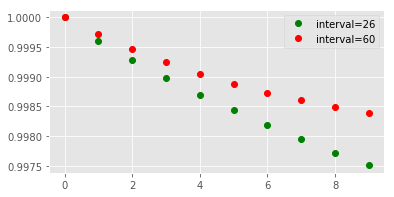

In [85]:
# for cell in [bushy,stellatet,stellatec]:
# individual_AP_E(rec_APsE(bushy,interval=30,n=10,tstop=350),interval=30,n=10)
APcost_on_Rate(bushy,noises=[0.],intervals=[26,60],clrs=['og','or'])

# Итого: Bushy тоже не изменяется. Так же, как и OC (распределенный)

## Оценка затрат в покое по Attwell и по Moujahid&D'Anjou


In [27]:
def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3

def pJ2atp(pJ):
    "pJ/s --> ATPs/s"
    return pmol2molecules(nJ2atp(pJ))

In [41]:
def mouj_Erate2_d(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    inah, ikh = split_ih(seg)# раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    
    acc_h = (abs(inah*(v-seg.ena)) + abs(ikh*(v-seg.ek)))*seg.area()*factor
    acc_klt = abs(seg.ik_klt*(v-seg.ek))*seg.area()*factor
    acc_ka = abs(seg.ik_ka*(v-seg.ek))*seg.area()*factor
    
    
    return array([acc*seg.area()*factor, acc_h, acc_klt, acc_ka])

In [98]:
def print_ratp_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    
    mouj_dh, mouj_h_dh, mouj_klt_dh = mouj_Erate2(cell(0.5))
#     mouj_atp = nJ2atp(mouj_dh)
    print "Attwell: %.3e pmol ATP/s"%attw
    print "Moujahid: %.3e pmol ATP/s"%mouj_atp
    print "A:M ratio: %2.3f"%(attw/mouj_atp)
    
def print_erate_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    seg = cell(0.5)
    mouj_set = mouj_Erate2_d(seg)[0]
#     mujpow = seg.erate_mujpow*seg.area()*1e-8
    attw_erate = atp2J(attw)
    print "Attwell: %.3e pJ/s"%attw_erate
    print "Moujahid: %.3e, pJ/s"%(mouj_set)
#     print "Mujpow dummy mech: %.3e pJ/s"%mujpow
    print "A:M ratio: %2.3f"%(attw_erate/mouj_set)

In [99]:
for npx in neurons:
    n = npx[0]
    print '===== ', n.name(), ' ====='
    print_erate_estimate(n)
    #print "Mujpow dummy mechanism: ", n.
    print '------\n'



=====  bushy  =====
Attwell: 2.151e+01 pJ/s
Moujahid: 9.044e+00, pJ/s
A:M ratio: 2.379
------

=====  octopus  =====
Attwell: 1.412e+02 pJ/s
Moujahid: 1.150e+02, pJ/s
A:M ratio: 1.227
------

=====  stellatec  =====
Attwell: 3.082e+00 pJ/s
Moujahid: 3.086e-01, pJ/s
A:M ratio: 9.985
------

=====  stellatet  =====
Attwell: 3.093e+00 pJ/s
Moujahid: 3.127e-01, pJ/s
A:M ratio: 9.892
------



In [100]:
# Plottin this sh*t (18.08.17 for article)
# -------------------------- Units: 1e9 ATP/s
def collect_MoujErates(neurons):
    Mes = dict()
    for npx in neurons:
        Mes[npx[0].name()] = pJ2atp(mouj_Erate2_d(npx[0](.5)))/1e9 # total, ih, ikl, ika
    return Mes

Mes = collect_MoujErates(neurons)
Mes = pandas.DataFrame(Mes,index=['Total','g$_h$','g$_{Klt}$','g$_{A}$']).T

In [101]:
Mes

,Total,g$_h$,g$_{Klt}$,g$_{A}$
bushy,0.108928,0.103315,0.004459,0.000000
octopus,1.385559,1.297766,0.082196,0.000000
stellatec,0.003717,0.002691,0.000000,0.000000
stellatet,0.003766,0.002789,0.000000,0.000045


In [102]:
Mes.Total = Mes.Total -Mes['g$_h$'] -Mes['g$_{Klt}$'] -Mes['g$_{A}$']

Mes = Mes.rename(index={'bushy':'BC','octopus':'OC','stellatet':'SC'}, columns={'Total':'Other'})

Mes=Mes.drop(['stellatec'])

In [107]:
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

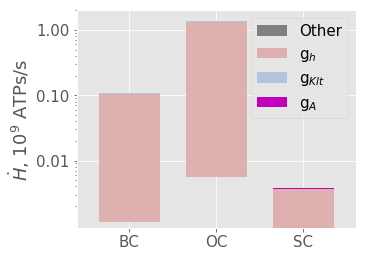

In [111]:


fig,ax = subplots(figsize=(5,4))
Mes.plot.bar(stacked=True,color=['grey','#deb0b0','#b0c4de', 'm'],width=0.7,rot=0,ax=ax)

yscale('log')
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('$\dot{H}$, $10^9$ ATPs/s')#, fontsize=15)
ax.yaxis.set_ticks([0.01,0.1,1.0])
# tight_layout()
# savefig('Point-models-resting-energy.svg')

## ≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠
## Добавляем синапсы 

In [30]:
# 18.08.17 for article >>>>>>>>>>>>>>>>>>>>>>
# Use single Synapses with Gbars from table 1 (RM03c) at 22 degC 

gsyns = {'octopus':8.6e-3, 'bushy':8.6e-3, 'stellatet':2.2e-3, 'stellatec':2.0e-3} # uS

In [31]:
# Source of stimuli
afib = h.NetStim() 

In [32]:
afib.interval = 1 # ms 
afib.start = 100 # ms
afib.number = 1 # number of spikes
afib.noise = 0.0 # no randomness so far

In [33]:
# All cells with a single 'resultant' synapse
synapses = dict()
connections = dict()

for i in range(4):
    cell = neurons[i][0]
    synapses[cell.name()] = h.ExpSyn(cell(.5))
    synapses[cell.name()].tau = 0.4 # RM03c p. 3099
    
    connections[cell.name()] = h.NetCon(afib, synapses[cell.name()],
                                        0,0, gsyns[cell.name()])


In [34]:
# recs_v = {k[0].name():h.Vector() for k in neurons}

In [35]:
afib.start = 1250

In [36]:
# ok
def setup_stim(cell, weight):
    connections[cell.name()].weight[0] = weight
    
def setup_pulse_stim(cell, amp=0, delay=1000, dur=3):
    Clamps[cell.name()].delay = delay
    Clamps[cell.name()].amp= amp
    Clamps[cell.name()].dur = dur

def find_threshold(cell, start_range, tol=0.01,
                   vthresh = -25,
                   setter=setup_stim):
    
    vax = h.Vector()
    vax.record(cell(0.5)._ref_v) 
    
#     if not hasattr(cell, 'stim'):
#         add_single_pulse_stim(cell)
 
    start_range = np.array(map(float, start_range)) # interval of IClamp amps in which to look for a threash amp
    min_range = tol*np.mean(start_range) # min interval. Sets presision
  
    def spikep(par):  # takes *parameter*, adds synapses to cell with the *parameter* and h.runs recording voltage
                        # Returns max value of voltage of depolarisation over time.
        setter(cell, par)
        if setter == setup_stim:
            h.tstop = afib.start + synapses[cell.name()].tau*10
        if setter == setup_pulse_stim:
            h.tstop = Clamps[cell.name()].delay + Clamps[cell.name()].dur + 1.0
        h.run()
        return array(vax).max()
    
    nfix = 10
    ntries = 0
    while not spikep(start_range[1])>vthresh: # "Is it AP?"
        start_range[1] *= 2.0 # if not, widen the min interval
        ntries += 1
        if ntries > nfix:
            print "Can't find threshold: max_amp isn't enough!"
            print "Giving up."
            return False
        
    
    def loop(begin, end):   # Provides boarders of start_range to approach min_range.
                            # Returns min IClamp current amp resulting to AP generation,
                            # and max voltage of the AP.
        if end-begin < min_range:
            return end, spikep(end)
        val = np.mean((begin, end))
        if spikep(val) > vthresh:
            return loop(begin, val)
        else:
            return loop(val, end)

    return loop(start_range[0], start_range[1])

# ok
def plot_around_th(cell, th, setter=setup_stim, coefs = [0.95, 1, 1.05]):
    f, axs = subplots(2,1,sharex=True, figsize=(9,9))
    
    tv = h.Vector()
    tv.record(h._ref_t)
    
    istim = h.Vector()
    if setter == setup_stim:
        istim.record(synapses[cell.name()]._ref_i)
    if setter == setup_pulse_stim:
        istim.record(Clamps[cell.name()]._ref_i)

    vax = h.Vector()
    vax.record(cell(0.5)._ref_v) 
    
    for c in coefs:
        setter(cell, c*th)
        h.run()
        axs[0].plot(tv, vax,  label='%0.2f th'%c)
        axs[1].plot(tv, istim,'k-', alpha=0.6)
#         setp(axs[1], ylim=(-0.1, amax(array(cell.istim))*1.2))

    axs[0].legend(loc='upper left')
    axs[0].set_ylabel('membrane potential, mV')
    setp(axs[1], xlabel='time, ms', ylabel='Istim')
    axs[0].set_xlim(h.tstop-10,h.tstop+10)
    axs[1].set_xlim(h.tstop-10,h.tstop+10)



In [37]:
%%time

ths = dict()
for n in neurons:
    nn = n[0].name()
    ths[nn] = find_threshold(n[0], array([0.01,0.1]), vthresh=0)

CPU times: user 28.2 s, sys: 31 ms, total: 28.2 s
Wall time: 28.3 s


In [38]:
print ths
print '------\nNo AP in Octopus cell... Try IClamp next'

{'stellatec': (0.010351562500000001, 42.905695325990749), 'octopus': (1.1473779296875, 0.00015763177135812156), 'bushy': (0.01984375, 15.853087341380027), 'stellatet': (0.010351562500000001, 38.781309658485213)}
------
No AP in Octopus cell... Try IClamp next


In [39]:
# Trying IClamp

Clamps = dict()
for n in neurons:
    Clamps[n[0].name()] = h.IClamp(0.5, sec=n[0])

In [40]:
ths_IC = dict()
for n in neurons:
    nn = n[0].name()
    ths_IC[nn] = find_threshold(n[0], array([1.,6.]), vthresh=0, setter=setup_pulse_stim)

In [41]:
ths_IC['octopus'] = find_threshold(neurons[1][0], array([2.,10.]), vthresh=50, setter=setup_pulse_stim)

In [42]:
print ths_IC
print '-------\nOctopus cells are extraordinarily unexcitable here...'

{'stellatec': (1.01953125, 48.159432224868013), 'octopus': (11.03515625, 50.059154584888105), 'bushy': (1.01953125, 36.520211970589258), 'stellatet': (1.01953125, 44.303250937685974)}
-------
Octopus cells are extraordinarily unexcitable here...


In [43]:
# 18.08.17 for article 

NameError: name 'octopus_rec' is not defined

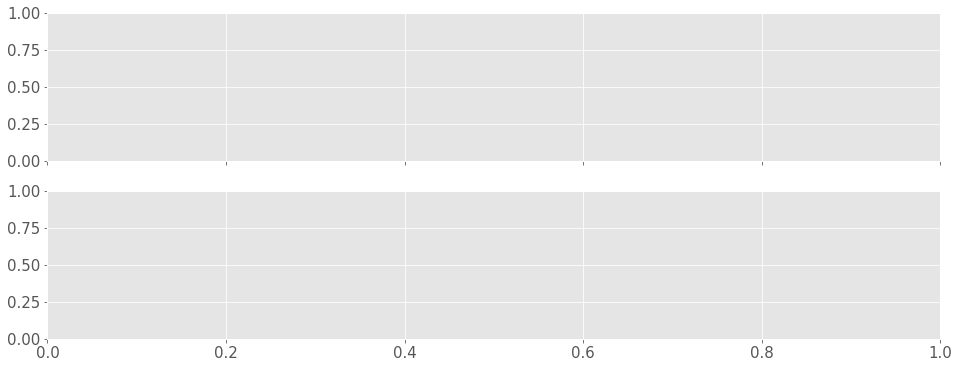

In [46]:
f, axs = subplots(2,1,sharex=True,figsize=(16,6))
axs[0].plot(t_vec, octopus_rec['v'], color='royalblue')
setp(axs[0], ylabel='V [mV]')
#axs[0].set_ylabel('V, mV')

axs[1].plot(t_vec, array(octopus_rec['erate'])*soma_area)
axs[1].set_ylabel('Erate, pJ/s')
#xlim(138,145)
#ylim(-2000,2000)
suptitle("Suprathreshold EPSPs",size=14)

## Simulation control from Python


In [47]:
def synaptic_curr2pJ(syn,seg):
    # syn.g is in uS, syn.i is in nA, erate is in pJ/s
    v  = seg.v
    g = syn.g
    ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena)
    erate = ina*(v-seg.ena) + ik*(v-seg.ek)
    return erate

In [50]:
connections

{'bushy': <hoc.HocObject at 0x10ff22f18>,
 'octopus': <hoc.HocObject at 0x10ee184f8>,
 'stellatec': <hoc.HocObject at 0x10fef55d0>,
 'stellatet': <hoc.HocObject at 0x1149bb198>}

In [51]:
h.dt = 0.01
tstop = 1300


for con in connections.values():
    con.weight[0] = 1e-3*30

def initialize():
    h.finitialize(h.v_init)
    h.fcurrent()

    
def integrate():
    #tstamps =  []
    #erate = []
    #v = []
    out = {key:[] for key in ['t','v','erate', 'syn_rate']}
    seg = octopus(0.5)
    while h.t < tstop:
        h.fadvance()
        #isyn = np.sum([syn.i for syn in synapses])
        syn_rate = np.sum([synaptic_curr2pJ(s, seg) for s in synapses])
        out['t'].append(h.t)
        out['v'].append(seg.v)
        out['erate'].append(mouj_Erate2(seg))
        out['syn_rate'].append(syn_rate)
    return {key:np.array(vec) for key,vec in out.items()}

def go():
    initialize()
    return integrate()
    
def plot_traj(traj):
    f, axs = subplots(2,1,sharex=True, figsize=(12,9))
    axs[0].plot(traj['t'], traj['v'],'b-')
    axs[0].set_ylabel('Voltage')
    axs[1].plot(traj['t'], traj['erate'], '-', label='ion channels')
    axs[1].plot(traj['t'], traj['syn_rate'], '-', color='orange', label='synaptic')
    legend()


data = go()
plot_traj(data)
xlim(99,102)

AttributeError: 'str' object has no attribute 'g'

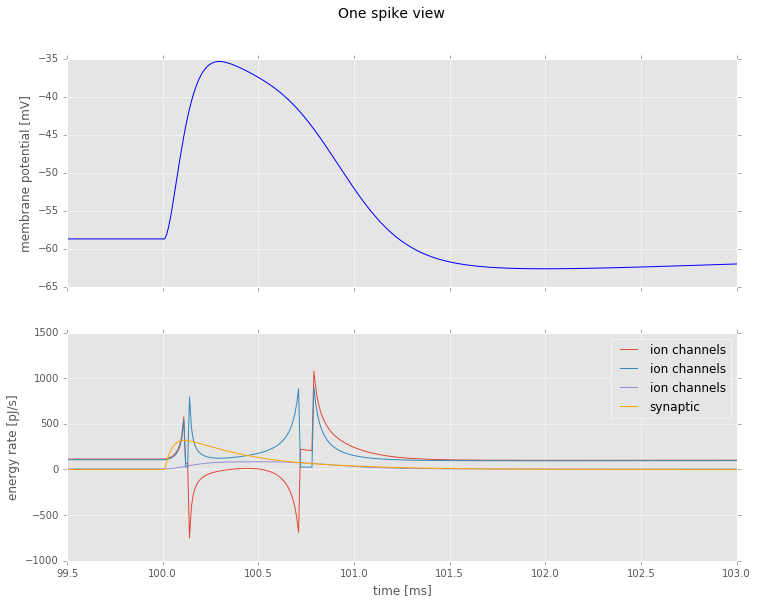

In [37]:
plot_traj(data)
xlim(99.5,103)
xlabel('time [ms]')
suptitle('One spike view',size=14)
setp(gcf().axes[0], ylabel='membrane potential [mV]')
setp(gcf().axes[1], ylabel='energy rate [pJ/s]')
legend()

In [39]:
def find_nearest(array, value):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(array - value).argmin()
    return idx

In [40]:
def active_to_rest_e(data, start, stop, delta):

    mi_r, mi_a = find_nearest(data['t'], start), find_nearest(data['t'], (start-delta)) # integration lims
    ma_r, ma_a = find_nearest(data['t'], stop), find_nearest(data['t'], (stop-delta))
    
    rest_e = 1e-3*(trapz(data['erate'][mi_r:ma_r], data['t'][mi_r:ma_r]) + trapz(data['syn_rate'][mi_r:ma_r], data['t'][mi_r:ma_r])*0)
    active_e = 1e-3*(trapz(data['erate'][mi_a:ma_a], data['t'][mi_a:ma_a]) + trapz(data['syn_rate'][mi_a:ma_a], data['t'][mi_a:ma_a])*0)
    ratio = active_e/rest_e
    return ratio, rest_e, active_e